# Analysis of physical activity (steps) logged by a smartwatch

## Table of contents
1. [Read the dataset and print basic statistics](#read)
2. Plots
  1. [Daily steps](#daily)
  1. [Average hourly steps during the day](#hourly)
  1. [Average 15-mins steps during the day](#15min)
  1. [Average steps per day of the week](#dow)

In [16]:
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib._color_data as mcd
from datetime import datetime
pd.plotting.register_matplotlib_converters()

In [17]:
DATA_FILES_DIR = 'user-site-export/'
OUTPUT_CHARTS_DIR = './'
DATE_FORMAT = "%d/%m/%Y"
TIMESTAMP_FORMAT = DATE_FORMAT + ' %H:%M'

In [18]:
def get_data(name, file_filter):
    print(f'Processing {name} data...')
    file_list = glob.glob(DATA_FILES_DIR + file_filter)
    dataList = []
    print(f'\tFound {len(file_list)} files to process')
    for file_name in file_list:
        with open(file_name,'r') as file_in:
            data = json.loads(file_in.read())
            dataList.extend(data)
    return pd.DataFrame(dataList)

In [19]:
# Check if dirs exist and create them if they don't
if not os.path.exists(DATA_FILES_DIR):
    print(f'ERROR: cannot find dir {DATA_FILES_DIR}')
if not os.path.exists(OUTPUT_CHARTS_DIR):
    os.makedirs(OUTPUT_CHARTS_DIR)

## Read the dataset and print basic statistics <a name="read"></a>

In [20]:
df = get_data("STEPS", "steps-*.json")
df.index = pd.to_datetime(df['dateTime'])
df['value'] = pd.to_numeric(df['value'], downcast='unsigned')
start_day = df.index[0]
end_day = df.index[-1]
print(f'\tData from {start_day.strftime(DATE_FORMAT)} to '
                f'{end_day.strftime(DATE_FORMAT)}, '
                f'{(end_day-start_day).days + 1:,} days, '
                f'{df.shape[0]:,} records')
print(f"\tMax spike {df['value'].max()} steps "
      f"at {df['value'].idxmax().strftime(TIMESTAMP_FORMAT)}")

Processing STEPS data...
	Found 26 files to process
	Data from 20/01/2019 to 08/02/2021, 751 days, 437,907 records
	Max spike 131 steps at 10/08/2020 08:21


## Daily steps <a name="daily"></a>

	Max daily 24,297 steps on 09/10/2019
	Min daily 0 steps on 02/12/2020
	Mean daily 5,286 steps
	Total 3,969,860 steps


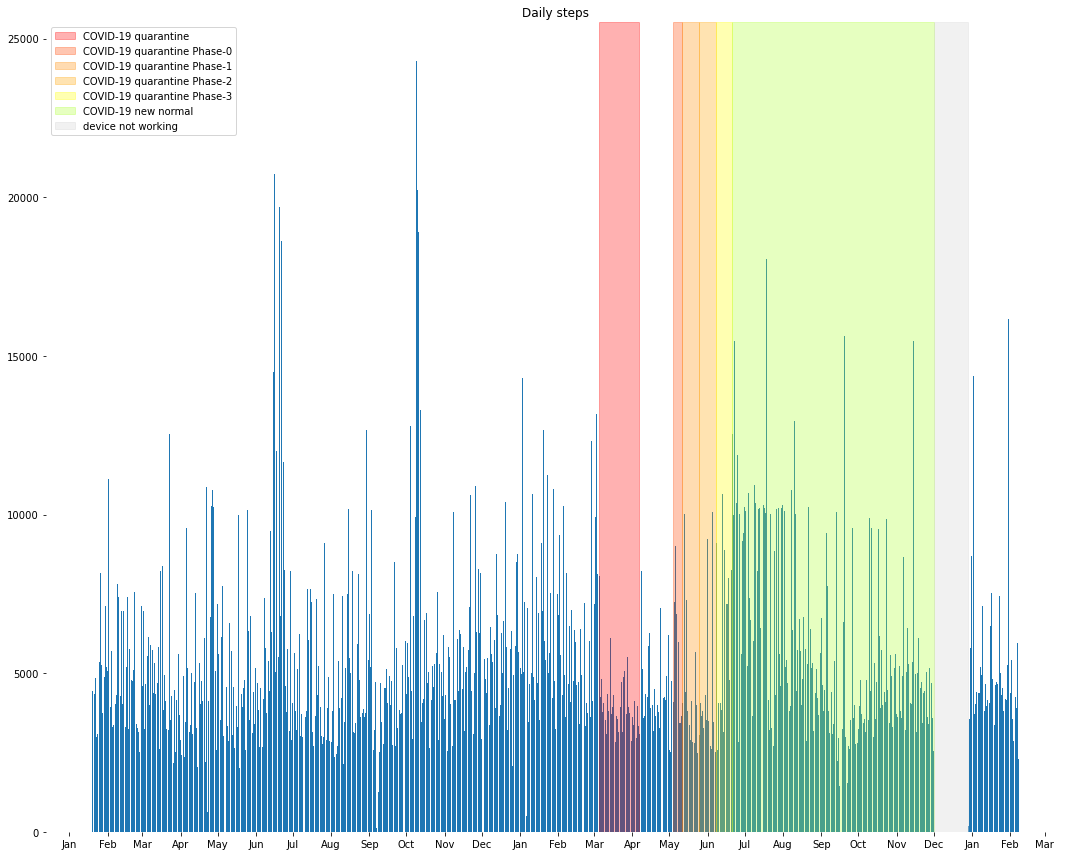

In [21]:
daily_steps = df['value'].resample('D').sum()
daily_steps = pd.to_numeric(daily_steps, downcast='unsigned')
print(f"\tMax daily {daily_steps.max():,} steps "
      f"on {daily_steps.idxmax().strftime(DATE_FORMAT)}")
print(f"\tMin daily {daily_steps.min()} steps "
      f"on {daily_steps.idxmin().strftime(DATE_FORMAT)}")
print(f"\tMean daily {daily_steps.mean():,.0f} steps")
print(f"\tTotal {daily_steps.sum():,} steps")
fig, ax = plt.subplots(figsize=(15, 12))
ax.bar(daily_steps.index, daily_steps)
plt.title(f'Daily steps')
plt.box(False)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# highlight the period of the COVID-19 quarantine!
ax.axvspan(datetime(2020, 3, 5), datetime(2020, 4, 6), alpha=0.3,
           color='red', label='COVID-19 quarantine')
ax.axvspan(datetime(2020, 5, 4), datetime(2020, 5, 11), alpha=0.3,
           color='orangered', label='COVID-19 quarantine Phase-0')
ax.axvspan(datetime(2020, 5, 11), datetime(2020, 5, 25), alpha=0.3,
           color='darkorange', label='COVID-19 quarantine Phase-1')
ax.axvspan(datetime(2020, 5, 25), datetime(2020, 6, 8), alpha=0.3,
           color='orange', label='COVID-19 quarantine Phase-2')
ax.axvspan(datetime(2020, 6, 8), datetime(2020, 6, 21), alpha=0.3,
           color='yellow', label='COVID-19 quarantine Phase-3')
ax.axvspan(datetime(2020, 6, 21), datetime(2020, 12, 1), alpha=0.3,
           color='greenyellow', label='COVID-19 new normal')
ax.axvspan(datetime(2020, 12, 1), datetime(2020, 12, 29), alpha=0.3,
           color='lightgray', label='device not working')
ax.legend()
plt.tight_layout()
plt.savefig(OUTPUT_CHARTS_DIR + 'daily_steps.png', dpi=300)

## Average hourly steps during the day <a name="hourly"></a>

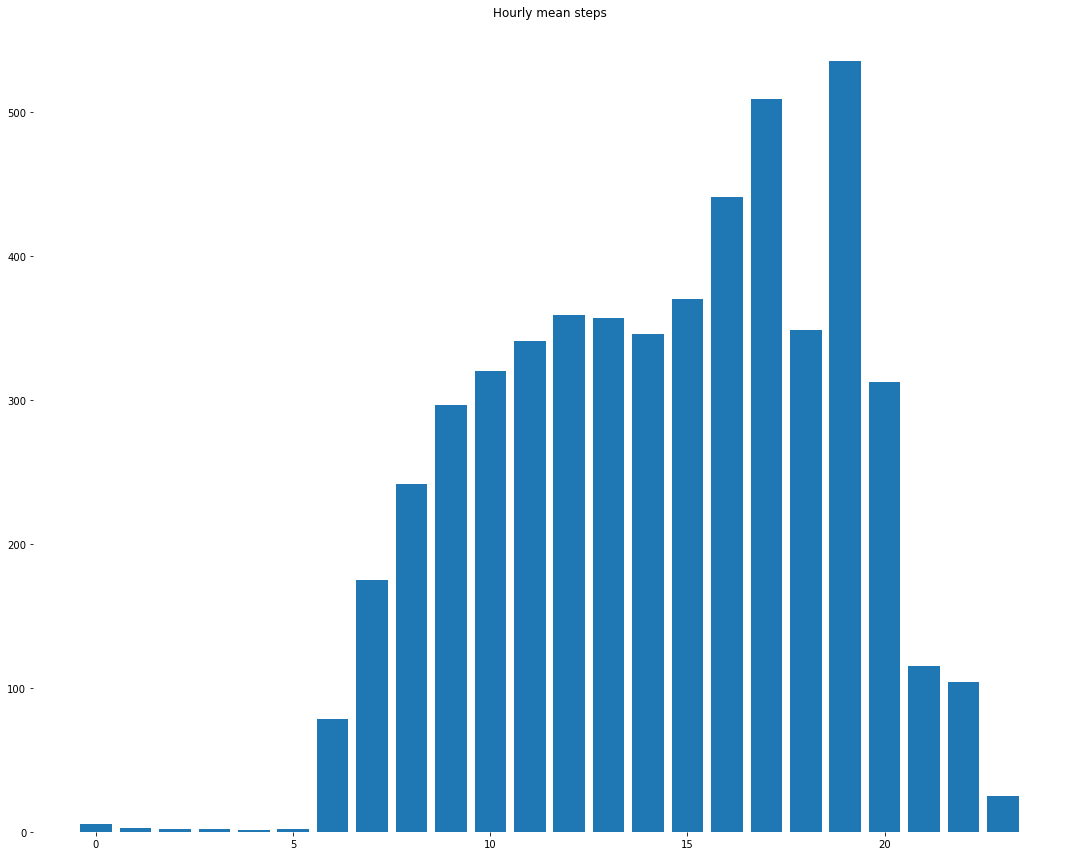

In [22]:
hourly_mean = df['value'].resample('H').sum()
hourly_mean = hourly_mean.groupby(hourly_mean.index.hour).mean()
fig, ax = plt.subplots(figsize=(15, 12))
ax.bar(hourly_mean.index, hourly_mean)
plt.title(f'Hourly mean steps')
plt.box(False)
plt.tight_layout()
plt.savefig(OUTPUT_CHARTS_DIR + 'hourly_mean_steps.png', dpi=300)

## Average 15-mins steps during the day <a name="15min"></a>

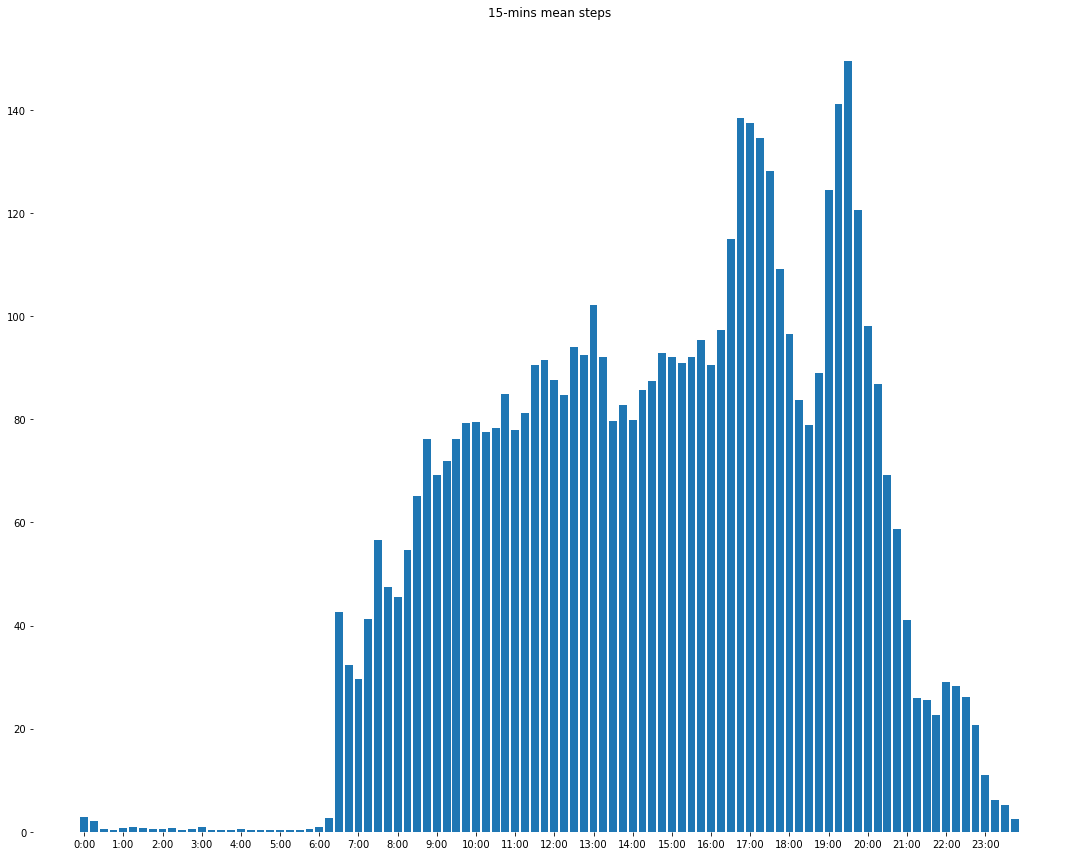

In [23]:
mins15_mean = df['value'].resample('15T').sum()
# now groupby hour+minute to get the daily average in the given 15-mins interval
mins15_mean = mins15_mean.groupby([mins15_mean.index.hour, mins15_mean.index.minute]).mean()
# revert the MultiIndex to a single DateTimeIndex so that we can use the HourLocator
mins15_mean.index = mins15_mean.index.map(lambda t: '{}:{:02}'.format(*t))
fig, ax = plt.subplots(figsize=(15, 12))
ax.bar(mins15_mean.index, mins15_mean)
plt.xticks(mins15_mean.index[::4])
plt.title(f'15-mins mean steps')
plt.box(False)
plt.tight_layout()
plt.savefig(OUTPUT_CHARTS_DIR + '15mins_mean_steps.png', dpi=300)

## Average steps per day of the week <a name="dow"></a>

	Average steps on Monday    4887
	Average steps on Tuesday   4950
	Average steps on Wednesday 4903
	Average steps on Thursday  4949
	Average steps on Friday    5243
	Average steps on Saturday  6731
	Average steps on Sunday    5378


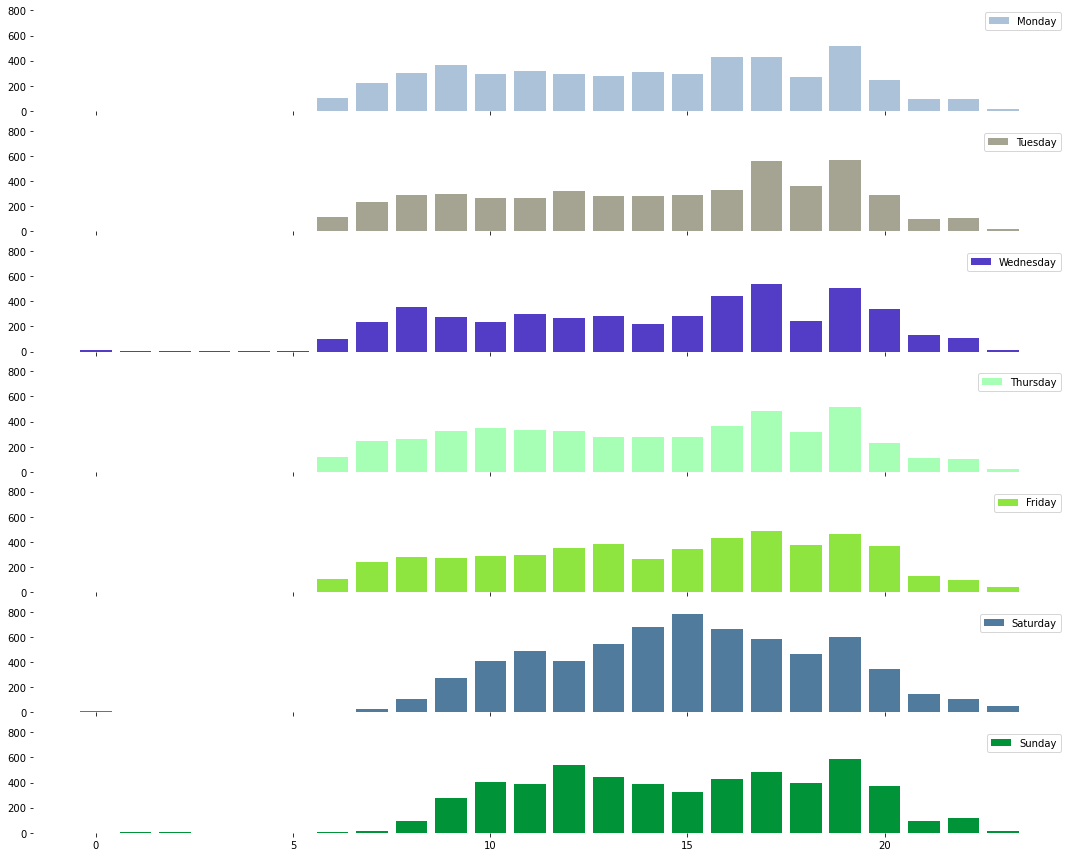

In [24]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',]
weekday_hourly_mean = df['value'].resample('H').sum()
weekday_hourly_mean = weekday_hourly_mean.groupby([weekday_hourly_mean.index.dayofweek,
                                                   weekday_hourly_mean.index.hour]).mean()
fig, axs = plt.subplots(7, 1, sharey=True, sharex=True, figsize=(15, 12))
for day in range(7):
    print(f'\tAverage steps on {days[day]: <9} {weekday_hourly_mean[day].sum():.0f}')
    ax = axs[day]
    ax.bar(weekday_hourly_mean[day].index, weekday_hourly_mean[day],
           # definitely not efficient choice of colors!
           label=f'{days[day]}', color=list(mcd.XKCD_COLORS.values())[day*11])
    ax.legend()
    # remove the frames of this subplot
    for pos in ['top', 'bottom', 'right', 'left']:
        ax.spines[pos].set_visible(False)
plt.tight_layout()
plt.savefig(OUTPUT_CHARTS_DIR + 'weekday_hourly_steps.png', dpi=300)